### 필요 라이브러리 설치 및 불러오기




In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize,sent_tokenize
import re # regular expression libary.
import nltk # Natural Language toolkit
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import sklearn.metrics 
import string
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import warnings
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
warnings.filterwarnings(action='ignore')
from wordcloud import WordCloud
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aytekin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aytekin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aytekin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Aytekin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# EDA

In [2]:
df = pd.read_csv('data/7allV03.csv',encoding='utf-8')
print(df.shape)
df.head()

(4900, 2)


,category,text
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...


In [7]:
# 결측치 제거 -> 결측치 없음
df.isna().sum()

category    0
text        0
dtype: int64

In [3]:
# 중복값 제거
print(df.duplicated().sum())
df = df.drop_duplicates()
df.shape

360


(4540, 2)

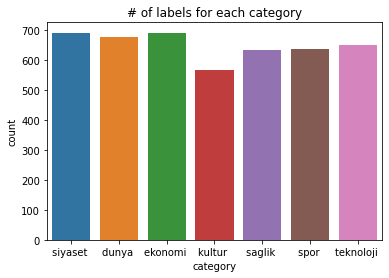

총 레이블 수 7
총 데이터 수 4540


In [9]:
sns.countplot("category",data=df)
plt.title('# of labels for each category')
plt.show() # balanced label
s = df['category'].nunique() # number of labels
n = df.shape[0]
print(f'총 레이블 수 {s}')
print(f'총 데이터 수 {n}')

In [10]:
df['length'] = [len(review) for review in df['text']]
print('길이 평균 : {}'.format(np.mean(df['length'])))
print('길이 최대 : {}'.format(np.max(df['length'])))
print('길이 최소 : {}'.format(np.min(df['length'])))

길이 평균 : 1980.8420704845814
길이 최대 : 19383
길이 최소 : 72


# Prerocessing

In [11]:
text_list=[]

for text in df.text:
    text = text.lower()  #Büyük harften -Küçük harfe çevirme
    text = re.sub("[^abcçdefgğhıijklmnoöprsştuüvyz]"," ",text)
    text=nltk.word_tokenize(text) # splits the words that are in the sentence from each other.
    text =[word for word in text if not word in set(stopwords.words("turkish"))] # remove stopword 
    text=" ".join(text)
    text_list.append(text) # store sentences in list

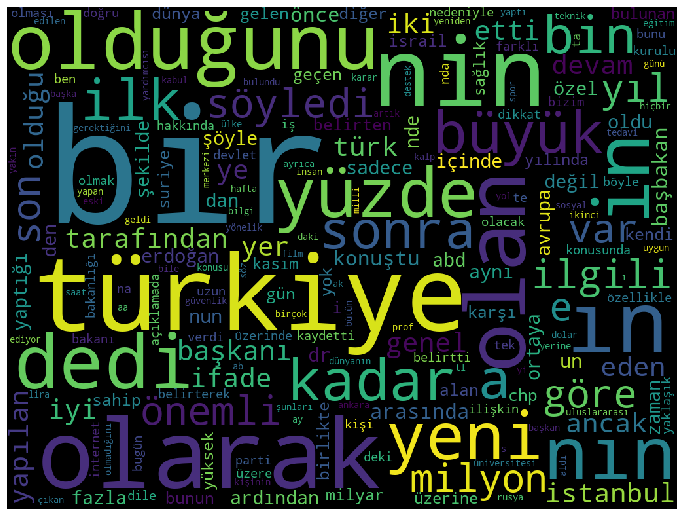

In [12]:
c = Counter(' '.join(text_list).split())

wc = WordCloud(background_color="black",width=1024,height=768).generate_from_frequencies(c)
plt.figure(figsize=(12,10))
plt.axis('off')
plt.imshow(wc, interpolation='nearest')
plt.show()

In [13]:
df['cleaned_text'] = text_list
df.head()

,category,text,length,cleaned_text
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...,6676,milyon ön seçim vaadi mhp nin olağan büyük kur...
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...,3313,mesut yılmaz yüce divan ceza alabilirdi prof d...
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...,5434,disko lar kaldırılıyor başbakan yardımcısı arı...
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...,658,sarıgül anayasa mahkemesi gidiyor mustafa sarı...
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...,1575,erdoğan idamın bir haklılık sebebi var demek y...


In [6]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df.category)
labels = le.transform(df.category)
df['label'] = labels
df.head()

,category,text,label
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...,4
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...,4
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...,4
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...,4
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...,4


In [7]:
# data split for train and test

train, test = train_test_split(df, test_size=0.2, random_state=42)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print(train.shape)
print(test.shape)

(3632, 3)
(908, 3)


In [16]:
train.head()

,category,text,length,cleaned_text,label
0,kultur,7 yaşındaki mercan a büyük ödül almanya nın e...,2202,yaşındaki mercan a büyük ödül almanya nın önem...,2
1,teknoloji,facebook kullanıcıları dikkat ! facebook un y...,1403,facebook kullanıcıları dikkat facebook un yeni...,6
2,saglik,organ bağışı vasiyeti herkesin cebinde olacak...,4639,organ bağışı vasiyeti herkesin cebinde olacak ...,3
3,ekonomi,çeyrek altın kaç lira istanbul_kapalıçarşı da...,559,çeyrek altın kaç lira istanbul kapalıçarşı aya...,1
4,ekonomi,borsa güne yükselişle başladı istanbul_menkul...,652,borsa güne yükselişle başladı istanbul menkul ...,1


In [17]:
test.head()

,category,text,length,cleaned_text,label
0,ekonomi,hollanda türkiye  nin büyümesini kıskanıyoru...,1694,hollanda türkiye nin büyümesini kıskanıyoruz h...,1
1,ekonomi,komşu türk turist çekmek için camileri bile o...,2007,komşu türk turist çekmek camileri bile onaraca...,1
2,kultur,ünlü eser sakıncalı bulundu izmir il milli_eğ...,1048,ünlü eser sakıncalı bulundu izmir il milli eği...,2
3,spor,ronaldo ile kıyaslanmaktan sıkılmış ! dünyanı...,1141,ronaldo kıyaslanmaktan sıkılmış dünyanın iyi i...,5
4,dunya,meksika da deprem meksika nın güneyinde şidde...,284,meksika deprem meksika nın güneyinde şiddetli ...,0


# modeling & evalutaion

## 1. ML - RandomForest

    CounterVectorizer vs TfidfVectorizer


In [153]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

MAX_FEATURES = 500

pipeline1 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf',RandomForestClassifier(random_state=42))
])
pipeline2 = Pipeline([
    ('vect', CountVectorizer(max_features=MAX_FEATURES)),
    ('clf',RandomForestClassifier(random_state=42))
])
pipeline3 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf',RandomForestClassifier(random_state=42))
])
pipeline4 = Pipeline([
    ('vect', TfidfVectorizer(max_features=MAX_FEATURES)),
    ('clf',RandomForestClassifier(random_state=42))
])

pipelines = [pipeline1, pipeline2, pipeline3, pipeline4]

for pipeline in pipelines:
    pipeline.fit(train['cleaned_text'],train['label'])

In [159]:
from sklearn.metrics import accuracy_score, f1_score

for pipeline in pipelines:
    y_preds = pipeline.predict(test['text'])
    f1_score_ = f1_score(test['label'],y_preds, average='weighted')
    accuracy_score_ = accuracy_score(test['label'],y_preds)
    print(pipeline)
    print(f'f1_score : {f1_score_}')
    print(f'acc_score : {accuracy_score_}')
    print('***'*30, '\n')

Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', RandomForestClassifier(random_state=42))])
f1_score : 0.8516704119698174
acc_score : 0.8513215859030837
****************************************************************************************** 

Pipeline(steps=[('vect', CountVectorizer(max_features=500)),
                ('clf', RandomForestClassifier(random_state=42))])
f1_score : 0.7729539271219579
acc_score : 0.7720264317180616
****************************************************************************************** 

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', RandomForestClassifier(random_state=42))])
f1_score : 0.8446461603468288
acc_score : 0.8447136563876652
****************************************************************************************** 

Pipeline(steps=[('vect', TfidfVectorizer(max_features=500)),
                ('clf', RandomForestClassifier(random_state=42))])
f1_score : 0.780308287423666
acc_score : 0.778634361233480

In [160]:
print('best model')
y_preds = pipeline1.predict(test['text'])
f1_score_ = f1_score(test['label'],y_preds, average='weighted')
accuracy_score_ = accuracy_score(test['label'],y_preds)
print(pipeline)
print()
print(f'f1_score : {f1_score_}')
print(f'f1_score : {accuracy_score_}')

best model
Pipeline(steps=[('vect', TfidfVectorizer(max_features=500)),
                ('clf', RandomForestClassifier(random_state=42))])

f1_score : 0.8516704119698174
f1_score : 0.8513215859030837


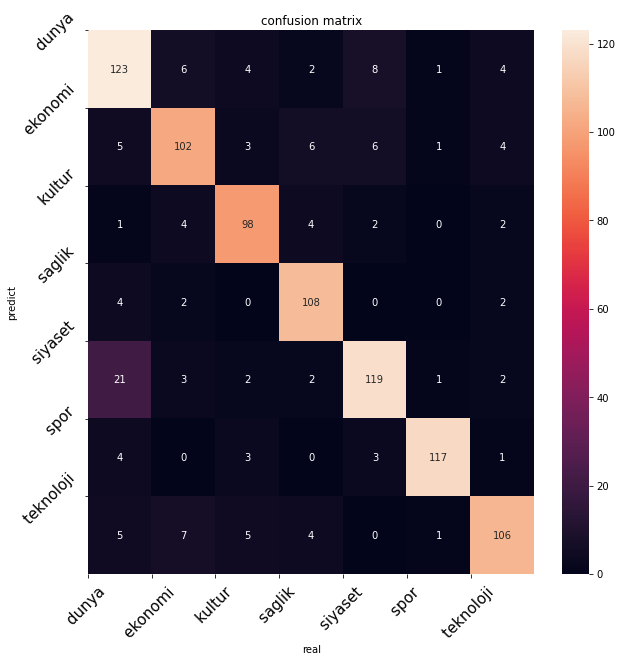

In [161]:
y_pred=pipeline1.predict(test['text'])

# confusion matrix
plt.figure(figsize=(10,10))
cm=confusion_matrix(test['label'],y_preds)
plt.title('confusion matrix')
sns.heatmap(cm,annot=True,fmt='d') 
plt.xticks(np.arange(0,7),le.classes_, size=15, rotation=45)
plt.yticks(np.arange(0,7),le.classes_, size=15, rotation=45)
plt.xlabel('real')
plt.ylabel('predict')
plt.show()

In [196]:
# model fine tuning
from sklearn.model_selection import RandomizedSearchCV

pipe = Pipeline([
    ('vect',CountVectorizer()),
    ('clf',RandomForestClassifier())
])

params={'clf__n_estimators':[50,100,500],
        "clf__max_depth":[8,10,15,20],
        "clf__max_features":[8,10,15,20],
        }

clf1 = RandomizedSearchCV(
    pipeline,
    param_distributions = params,
    n_iter = 1000,
    cv = 5,
    verbose=3,
    random_state=42
)

clf1.fit(train['cleaned_text'],train['label'])

[CV 4/5] END clf__max_depth=10, clf__max_features=20, clf__n_estimators=50;, score=0.723 total time=   1.7s
[CV 5/5] END clf__max_depth=10, clf__max_features=20, clf__n_estimators=50;, score=0.741 total time=   1.7s
[CV 1/5] END clf__max_depth=10, clf__max_features=20, clf__n_estimators=100;, score=0.724 total time=   2.2s
[CV 2/5] END clf__max_depth=10, clf__max_features=20, clf__n_estimators=100;, score=0.741 total time=   2.0s
[CV 3/5] END clf__max_depth=10, clf__max_features=20, clf__n_estimators=100;, score=0.729 total time=   2.0s
[CV 4/5] END clf__max_depth=10, clf__max_features=20, clf__n_estimators=100;, score=0.752 total time=   2.0s
[CV 5/5] END clf__max_depth=10, clf__max_features=20, clf__n_estimators=100;, score=0.752 total time=   2.0s
[CV 1/5] END clf__max_depth=10, clf__max_features=20, clf__n_estimators=500;, score=0.743 total time=   5.3s
[CV 2/5] END clf__max_depth=10, clf__max_features=20, clf__n_estimators=500;, score=0.750 total time=   5.2s
[CV 3/5] END clf__max

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(max_features=500)),
                                             ('clf',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=1000,
                   param_distributions={'clf__max_depth': [8, 10, 15, 20],
                                        'clf__max_features': [8, 10, 15, 20],
                                        'clf__n_estimators': [50, 100, 500]},
                   random_state=42, verbose=3)

In [197]:
print('최적 하이퍼파라미터: ', clf1.best_params_)
print('검증 정확도:', clf1.best_score_)

최적 하이퍼파라미터:  {'clf__n_estimators': 500, 'clf__max_features': 8, 'clf__max_depth': 20}
검증 정확도: 0.8103023482290708


## 2. Fasttext



    facebook에서 만든 word embedding알고리즘  
    
    classifier 모델은 어떤 걸 쓰는지?  
    즉 embedding 방법과 clf방법을 숙지해놓아야 함.

In [24]:
#Data prepare for fasttext format for train
train["label_format"]=0
for i in range(len(train)):
    train.label_format[i]="__label__"+str(train.category[i])+" "+str(train.cleaned_text[i])

#Data prepare for fasttext format for test
test["label_format"]=0
for i in range(len(test)):
    test.label_format[i]="__label__"+str(test.category[i])+" "+str(test.cleaned_text[i])

fasttext에서는 라벨값을 ' __ label __ [카테고리명]' 이런 식으로 인식한다

라이브러리 요구사항에 맞게 전처리를 해주어야 함.

In [25]:
train.head()

,category,text,cleaned_text,label,label_format
0,kultur,7 yaşındaki mercan a büyük ödül almanya nın e...,yaşındaki mercan a büyük ödül almanya nın önem...,2,__label__kultur yaşındaki mercan a büyük ödül...
1,teknoloji,facebook kullanıcıları dikkat ! facebook un y...,facebook kullanıcıları dikkat facebook un yeni...,6,__label__teknoloji facebook kullanıcıları dik...
2,saglik,organ bağışı vasiyeti herkesin cebinde olacak...,organ bağışı vasiyeti herkesin cebinde olacak ...,3,__label__saglik organ bağışı vasiyeti herkesi...
3,ekonomi,çeyrek altın kaç lira istanbul_kapalıçarşı da...,çeyrek altın kaç lira istanbul kapalıçarşı aya...,1,__label__ekonomi çeyrek altın kaç lira istanb...
4,ekonomi,borsa güne yükselişle başladı istanbul_menkul...,borsa güne yükselişle başladı istanbul menkul ...,1,__label__ekonomi borsa güne yükselişle başlad...


In [26]:
test.head()

,category,text,cleaned_text,label,label_format
0,ekonomi,hollanda türkiye  nin büyümesini kıskanıyoru...,hollanda türkiye nin büyümesini kıskanıyoruz h...,1,__label__ekonomi hollanda türkiye nin büyümes...
1,ekonomi,komşu türk turist çekmek için camileri bile o...,komşu türk turist çekmek camileri bile onaraca...,1,__label__ekonomi komşu türk turist çekmek cam...
2,kultur,ünlü eser sakıncalı bulundu izmir il milli_eğ...,ünlü eser sakıncalı bulundu izmir il milli eği...,2,__label__kultur ünlü eser sakıncalı bulundu i...
3,spor,ronaldo ile kıyaslanmaktan sıkılmış ! dünyanı...,ronaldo kıyaslanmaktan sıkılmış dünyanın iyi i...,5,__label__spor ronaldo kıyaslanmaktan sıkılmış...
4,dunya,meksika da deprem meksika nın güneyinde şidde...,meksika deprem meksika nın güneyinde şiddetli ...,0,__label__dunya meksika deprem meksika nın gün...


In [28]:
train['label_format'].to_csv('fasttext_train.txt',index=None,header=None)
test['label_format'].to_csv('fasttext_test.txt',index=None,header=None)

In [29]:
import fasttext
#train classifier model
model_fasttext = fasttext.train_supervised('fasttext_train.txt',
                                           epoch=50,
                                           lr=0.05,
                                           label_prefix='__label__',
                                           dim=1000)

In [31]:
model_fasttext.save_model("clf_model_turkish.bin")

학습된 모델 점수 및 성능확인

In [35]:
print(test['category'][0])
print(test['cleaned_text'][0])

ekonomi 
hollanda türkiye nin büyümesini kıskanıyoruz hollanda başbakanı mark rutte türkiye nin hollanda nın önemli ticaret yatırım ortaklarından birisi olduğunu belirterek son yıl içinde türkiye ekonomisi büyük bir hızla büyüdü büyüme bizi kıskandırıyor dedi türkiye nin yumuşak inişi başardığını aktaran rutte türkiye halen yüzde e yakın bir büyüme kaydedebiliyor dedi iki ülkenin yıllık toplam ticaret hacminin yıllık milyar doların üzerinde olduğunu anlatan rutte cumhurbaşkanı abdullah gül başbakan recep tayyip erdoğan görüşmeler yaptık görüşmeler sadece politik meselelerden ibaret değildi aynı zamanda iki ülke arasındaki ticari ekonomik ilişkileri artırabileceğimizi görüştük konuştu rutte kredi derecelendirme kuruluşu fitch in türkiye hakkında yaptığı not artırımı dolayısıyla başbakan erdoğan ı tebrik ettiğini belirterek not artırımı türkiye güzel bir haber türkiye artık istikrarlı bir ortam sağlıyor konuştu milyar dolar başbakan yardımcısı ali babacan yılın türkiye hollanda nın ikili

In [36]:
print(test['category'][0])
print(test['cleaned_text'][0])
print(model_fasttext.predict(test['cleaned_text'][0]))

ekonomi 
hollanda türkiye nin büyümesini kıskanıyoruz hollanda başbakanı mark rutte türkiye nin hollanda nın önemli ticaret yatırım ortaklarından birisi olduğunu belirterek son yıl içinde türkiye ekonomisi büyük bir hızla büyüdü büyüme bizi kıskandırıyor dedi türkiye nin yumuşak inişi başardığını aktaran rutte türkiye halen yüzde e yakın bir büyüme kaydedebiliyor dedi iki ülkenin yıllık toplam ticaret hacminin yıllık milyar doların üzerinde olduğunu anlatan rutte cumhurbaşkanı abdullah gül başbakan recep tayyip erdoğan görüşmeler yaptık görüşmeler sadece politik meselelerden ibaret değildi aynı zamanda iki ülke arasındaki ticari ekonomik ilişkileri artırabileceğimizi görüştük konuştu rutte kredi derecelendirme kuruluşu fitch in türkiye hakkında yaptığı not artırımı dolayısıyla başbakan erdoğan ı tebrik ettiğini belirterek not artırımı türkiye güzel bir haber türkiye artık istikrarlı bir ortam sağlıyor konuştu milyar dolar başbakan yardımcısı ali babacan yılın türkiye hollanda nın ikili

In [47]:
# test score
train_score = model_fasttext.test('fasttext_train.txt')
test_score = model_fasttext.test('fasttext_test.txt')

print("train Precision at 1 : {}, recall at 1 : {}:".format(train_score[1], train_score[2]))
print("test Precision at 1 : {}, recall at 1 : {}:".format(test_score[1], test_score[2]))

train Precision at 1 : 0.9509911894273128, recall at 1 : 0.9509911894273128:
test Precision at 1 : 0.8777533039647577, recall at 1 : 0.8777533039647577:


In [ ]:
y_test = test['label']

y_pred_label = []
for text in test['cleaned_text']:
    text = model_fasttext.predict(text)[0][0][9:] + ' '
    y_pred_label.append(text)
    y_pred = le.transform(y_pred_label)

In [98]:
print(sklearn.metrics.classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8759    0.8108    0.8421       148
           1     0.8106    0.8425    0.8263       127
           2     0.7953    0.9099    0.8487       111
           3     0.9000    0.9310    0.9153       116
           4     0.8947    0.9067    0.9007       150
           5     1.0000    0.8906    0.9421       128
           6     0.8810    0.8672    0.8740       128

    accuracy                         0.8778       908
   macro avg     0.8796    0.8798    0.8785       908
weighted avg     0.8813    0.8778    0.8783       908



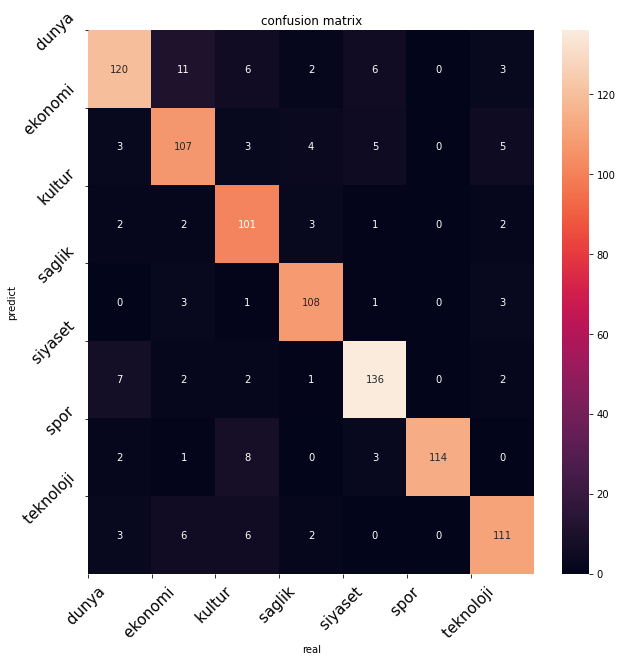

In [85]:
# confusion matrix
plt.figure(figsize=(10,10))
cm=confusion_matrix(y_test,y_pred)
plt.title('confusion matrix')
sns.heatmap(cm,annot=True,fmt='d') 
plt.xticks(np.arange(0,7),le.classes_, size=15, rotation=45)
plt.yticks(np.arange(0,7),le.classes_, size=15, rotation=45)
plt.xlabel('real')
plt.ylabel('predict')
plt.show()

## LSTM

In [231]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['label'], test_size=0.2, random_state=42,shuffle=True)
print(len(X_train)) # 3920 sentences
print(len(y_train)) #3920 Labels
print(len(X_test))  # 980 sentences
print(len(y_test)) # 980 labels

3632
3632
908
908


In [200]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

max_lenght=100

tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index # creating word dict for words in training

sequences = tokenizer.texts_to_sequences(X_train)  # replacing words with the number corresponding to them in the dictionary(word_index)

X_train_padded = pad_sequences(sequences, padding='post',maxlen=max_lenght) # padding words

print(len(word_index)) # I have 94836 words in my dictionary

94781


In [235]:
print("Original Version:",X_train.iloc[0])
print("\n---------------------------------\n")
print("Tokenized version:",sequences[0])  # change words with number that corresponding to word word_index
print("\n---------------------------------\n")
print("Padded version",X_train_padded[0]) 
print("\n---------------------------------\n")
print("Shape after the padding:",X_train_padded.shape)

Original Version: yaşındaki mercan a büyük ödül almanya nın önemli medya ödülü olarak kabul edilen bambi ödülleri düsseldorf kentinde düzenlenen törenle yılki sahiplerini buldu hubert burda media yayın kuruluşu tarafından düzenlenen törende christian zübert in dreiviertelmond filminde hayat adlı türk kızını canlandıran yaşındaki mercan fatma türkoğlu yetenek bambi ödülüne layık görüldü minik mercan sahneye gelerek anneme okuluma öğretmenlerime bana bugün burada olmama izin verdikleri teşekkür ediyorum dedi mercan fatma türkoğlu ödülünü kendi yaşıtı olan kendisi oyunculuk yapan nina eichinger den aldı geceden kareler foto galeri yeni başlayanlar türkçe adlı film ulusal film kategorisinde bambi ödülü alırken uyum dalındaki ödülü berlin sokak ortasında arap kökenli gençler tarafından dövülen haham daniel alter aldı yeni başlayanlar türkçe adlı filmin başrol oyuncusu adnan maral türkçe yaptığı teşekkür konuşmasında teşekkür ederim dedi alman birinci televizyonu ard tarafından naklen yayınl

In [ ]:
X_test_sequences = tokenizer.texts_to_sequences(X_train)  # replacing words with the number corresponding to them in the dictionary(word_index)
X_test_padded = pad_sequences(X_test_sequences, padding='post',maxlen=max_lenght) # padding words

In [234]:
print("Original Version:",X_test.iloc[0])
print("\n---------------------------------\n")
print("Tokenized version:",X_test_sequences[0])  # change words with number that corresponding to word word_index
print("\n---------------------------------\n")
print("Padded version",X_test_padded[0]) 
print("\n---------------------------------\n")
print("Shape after the padding:",X_test_padded.shape)

Original Version: hollanda türkiye nin büyümesini kıskanıyoruz hollanda başbakanı mark rutte türkiye nin hollanda nın önemli ticaret yatırım ortaklarından birisi olduğunu belirterek son yıl içinde türkiye ekonomisi büyük bir hızla büyüdü büyüme bizi kıskandırıyor dedi türkiye nin yumuşak inişi başardığını aktaran rutte türkiye halen yüzde e yakın bir büyüme kaydedebiliyor dedi iki ülkenin yıllık toplam ticaret hacminin yıllık milyar doların üzerinde olduğunu anlatan rutte cumhurbaşkanı abdullah gül başbakan recep tayyip erdoğan görüşmeler yaptık görüşmeler sadece politik meselelerden ibaret değildi aynı zamanda iki ülke arasındaki ticari ekonomik ilişkileri artırabileceğimizi görüştük konuştu rutte kredi derecelendirme kuruluşu fitch in türkiye hakkında yaptığı not artırımı dolayısıyla başbakan erdoğan ı tebrik ettiğini belirterek not artırımı türkiye güzel bir haber türkiye artık istikrarlı bir ortam sağlıyor konuştu milyar dolar başbakan yardımcısı ali babacan yılın türkiye hollanda 

In [236]:
y_train_label=np.asarray(y_train).reshape(-1,1)
y_test_label=np.asarray(y_test).reshape(-1,1)

In [237]:
import tensorflow as tf

vocab_size = len(tokenizer.word_index)+1
embedding_dim=16

model_lstm2 = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=100),
  tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2),
  tf.keras.layers.Dense(7, activation='softmax')
])

model_lstm2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_lstm2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           1516512   
                                                                 
 lstm (LSTM)                 (None, 128)               74240     
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 1,591,655
Trainable params: 1,591,655
Non-trainable params: 0
_________________________________________________________________


In [238]:
num_epochs = 10
BATCH_SIZE=64
history=model_lstm2.fit(X_train_padded,y_train_label,batch_size=BATCH_SIZE ,epochs=num_epochs, validation_data=(X_test_padded,y_test_label))

Epoch 1/10
57/57 [==============================] - 17s 231ms/step - loss: 1.9142 - accuracy: 0.1839 - val_loss: 1.8039 - val_accuracy: 0.2489
Epoch 2/10
57/57 [==============================] - 13s 223ms/step - loss: 1.6040 - accuracy: 0.2932 - val_loss: 1.5153 - val_accuracy: 0.3756
Epoch 3/10
57/57 [==============================] - 13s 221ms/step - loss: 1.3112 - accuracy: 0.4375 - val_loss: 1.4460 - val_accuracy: 0.4141
Epoch 4/10
57/57 [==============================] - 11s 197ms/step - loss: 1.0844 - accuracy: 0.5584 - val_loss: 1.3433 - val_accuracy: 0.4813
Epoch 5/10
57/57 [==============================] - 14s 243ms/step - loss: 0.8457 - accuracy: 0.6688 - val_loss: 1.3603 - val_accuracy: 0.5011
Epoch 6/10
57/57 [==============================] - 13s 230ms/step - loss: 0.6612 - accuracy: 0.7511 - val_loss: 1.3667 - val_accuracy: 0.5396
Epoch 7/10
57/57 [==============================] - 12s 204ms/step - loss: 0.6252 - accuracy: 0.7960 - val_loss: 1.2617 - val_accuracy: 0.5859

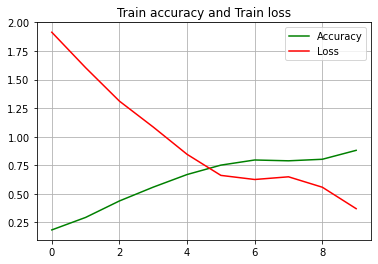

In [239]:
# model_lstm
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"],color="green")
plt.plot(history.history["loss"],color="red")
plt.title("Train accuracy and Train loss")
plt.legend(["Accuracy","Loss"])
plt.grid()

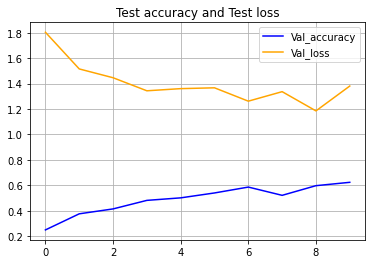

In [240]:
# model_lstm
plt.plot(history.history["val_accuracy"],color="blue")
plt.plot(history.history["val_loss"],color="orange")
plt.title("Test accuracy and Test loss")
plt.legend(["Val_accuracy","Val_loss"])
plt.grid()

In [241]:
import tensorflow as tf

vocab_size = len(tokenizer.word_index)+1
embedding_dim=16

model_lstm2 = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=100),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(7, activation='softmax')
])

adam= tf.keras.optimizers.Adam(lr=0.01) 

model_lstm2.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model_lstm2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           1516512   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              41472     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)               

In [242]:
num_epochs = 10
BATCH_SIZE=64
history2=model_lstm2.fit(X_train_padded,y_train_label,batch_size=BATCH_SIZE ,epochs=num_epochs, validation_data=(X_test_padded,y_test_label))

Epoch 1/10
57/57 [==============================] - 12s 128ms/step - loss: 1.9767 - accuracy: 0.2453 - val_loss: 1.8486 - val_accuracy: 0.2863
Epoch 2/10
57/57 [==============================] - 6s 100ms/step - loss: 0.9264 - accuracy: 0.6624 - val_loss: 1.2971 - val_accuracy: 0.5771
Epoch 3/10
57/57 [==============================] - 5s 94ms/step - loss: 0.2882 - accuracy: 0.9083 - val_loss: 1.1889 - val_accuracy: 0.5705
Epoch 4/10
57/57 [==============================] - 6s 114ms/step - loss: 0.0676 - accuracy: 0.9843 - val_loss: 1.0840 - val_accuracy: 0.6278
Epoch 5/10
57/57 [==============================] - 6s 105ms/step - loss: 0.0284 - accuracy: 0.9948 - val_loss: 1.0469 - val_accuracy: 0.6619
Epoch 6/10
57/57 [==============================] - 5s 95ms/step - loss: 0.0181 - accuracy: 0.9961 - val_loss: 1.0016 - val_accuracy: 0.7148
Epoch 7/10
57/57 [==============================] - 7s 125ms/step - loss: 0.0223 - accuracy: 0.9959 - val_loss: 1.1922 - val_accuracy: 0.6762
Epoch 8

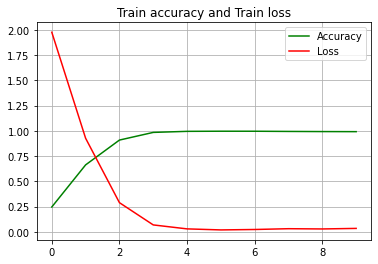

In [243]:
# model_lstm2
import matplotlib.pyplot as plt

plt.plot(history2.history["accuracy"],color="green")
plt.plot(history2.history["loss"],color="red")
plt.title("Train accuracy and Train loss")
plt.legend(["Accuracy","Loss"])
plt.grid()

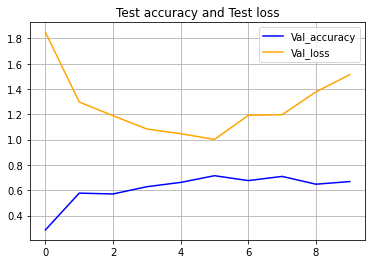

In [244]:
# model_lstm2
plt.plot(history2.history["val_accuracy"],color="blue")
plt.plot(history2.history["val_loss"],color="orange")
plt.title("Test accuracy and Test loss")
plt.legend(["Val_accuracy","Val_loss"])
plt.grid()

114/114 [==============================] - 2s 21ms/step - loss: 0.0654 - accuracy: 0.9846
Accuracy of the model on Training Data is -  98.4581470489502 %
29/29 [==============================] - 1s 18ms/step - loss: 1.5130 - accuracy: 0.6685
Accuracy of the model on Testing Data is -  66.85022115707397 %
29/29 [==============================] - 1s 18ms/step


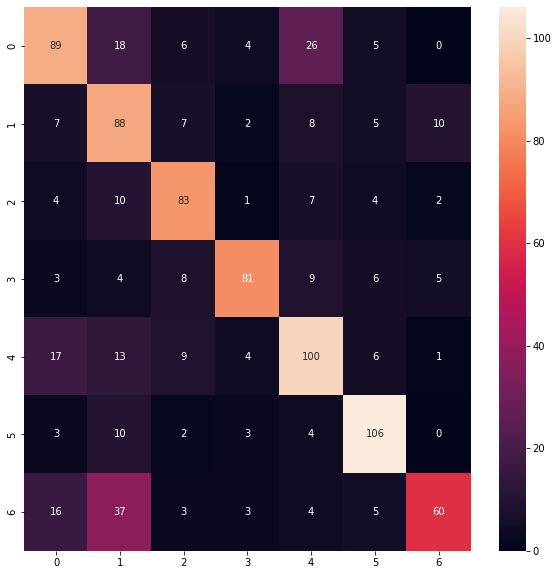

In [246]:
print("Accuracy of the model on Training Data is - " , model_lstm2.evaluate(X_train_padded,y_train_label)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model_lstm2.evaluate(X_test_padded,y_test_label)[1]*100 , "%")

pred = np.argmax(model_lstm2.predict(X_test_padded),axis=1)
cm = confusion_matrix(y_test,pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,linecolor="white",fmt='')
plt.show()
# overfitted on training data

## Deep learning - BERTurkish


In [4]:
from simpletransformers.classification import ClassificationModel
import torch
torch.cuda.is_available()

True

In [8]:
#for bert text column should be string and label column should be int
train["text"]=train["text"].apply(lambda r: str(r))
train['label']=train['label'].astype(int)

In [9]:
#create model with turkish bert - transfer learning
model = ClassificationModel('bert', 'dbmdz/bert-base-turkish-uncased', num_labels=7,use_cuda=True,
                            args={'reprocess_input_data': True, 
                                  'overwrite_output_dir': True, 
                                  'num_train_epochs': 3, 
                                  "train_batch_size": 64 , 
                                  "fp16":False,
                                  "output_dir": "bert_model"})

Some weights of the model checkpoint at dbmdz/bert-base-turkish-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

In [10]:
train = train[['text','label']]
test = test[['text','label']]

In [11]:
#train model
model.train_model(train)

  0%|          | 0/3632 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/57 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/57 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/57 [00:00<?, ?it/s]

(171, 0.4639796574561917)

In [12]:
result, model_outputs, wrong_predictions = model.eval_model(test)

  0%|          | 0/908 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/114 [00:00<?, ?it/s]

In [14]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

predictions = model_outputs.argmax(axis=1)
actuals = test.label.values
print(metrics.classification_report(actuals, predictions, digits=3))
accuracy_score(actuals, predictions)

              precision    recall  f1-score   support

           0      0.936     0.885     0.910       148
           1      0.851     0.811     0.831       127
           2      0.929     0.937     0.933       111
           3      0.947     0.931     0.939       116
           4      0.892     0.933     0.912       150
           5      0.984     0.992     0.988       128
           6      0.896     0.945     0.920       128

    accuracy                          0.919       908
   macro avg      0.919     0.919     0.919       908
weighted avg      0.919     0.919     0.918       908



0.9185022026431718